# 1. Load Dataset

In [1]:
import pandas as pd
import numpy as np

df = pd.read_excel("bank.xlsx")

In [2]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
age          4521 non-null int64
job          4521 non-null object
marital      4521 non-null object
education    4521 non-null object
default      4521 non-null object
balance      4521 non-null int64
housing      4521 non-null object
loan         4521 non-null object
contact      4521 non-null object
day          4521 non-null int64
month        4521 non-null object
duration     4521 non-null int64
campaign     4521 non-null int64
pdays        4521 non-null int64
previous     4521 non-null int64
poutcome     4521 non-null object
y            4521 non-null object
dtypes: int64(7), object(10)
memory usage: 600.5+ KB


# 2. Convert Target to 1/0

In [4]:
df['target'] = df['y'].apply(lambda x: 1 if x == 'yes' else 0)

In [5]:
df.target.value_counts()

0    4000
1     521
Name: target, dtype: int64

In [6]:
df.drop('y',axis=1,inplace=True)

# 3. Descriptive Stats

In [7]:
df.target.value_counts()/len(df)

0    0.88476
1    0.11524
Name: target, dtype: float64

In [8]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous,target
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579,0.115240
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562,0.319347
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000,1.000000


In [9]:
df.isnull().mean().sort_values(ascending=False)*100

target       0.0
loan         0.0
job          0.0
marital      0.0
education    0.0
default      0.0
balance      0.0
housing      0.0
contact      0.0
poutcome     0.0
day          0.0
month        0.0
duration     0.0
campaign     0.0
pdays        0.0
previous     0.0
age          0.0
dtype: float64

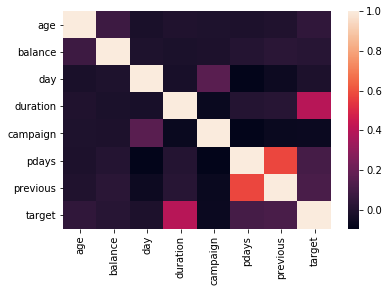

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
corr = df.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

# 4. Variable Selection using Python - Vote based approach

In [11]:
# Data transformation
# Convert categorical values to numeric using label encoder
from sklearn import preprocessing
from collections import defaultdict
d = defaultdict(preprocessing.LabelEncoder)

# Encoding the categorical variable
fit = df.select_dtypes(include=['object']).fillna('NA').apply(lambda x: d[x.name].fit_transform(x))

#Convert the categorical columns based on encoding
for i in list(d.keys()):
    df[i] = d[i].transform(df[i].fillna('NA'))

In [12]:
features = df[df.columns.difference(['target'])]
labels = df['target']

In [13]:
features = features.fillna(0)

## 4.1 WOE and IV

In [14]:
# import packages
import pandas as pd
import numpy as np
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

max_bin = 20
force_bin = 5

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.sum().EVENT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.EVENT_RATE/d3.NON_EVENT_RATE)
    d3["IV"] = (d3.EVENT_RATE-d3.NON_EVENT_RATE)*np.log(d3.EVENT_RATE/d3.NON_EVENT_RATE)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    df2 = df1.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.groups
    d3["MAX_VALUE"] = df2.groups
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y     
    d3["EVENT_RATE"] = d3.EVENT/d3.sum().EVENT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.EVENT_RATE/d3.NON_EVENT_RATE)
    d3["IV"] = (d3.EVENT_RATE-d3.NON_EVENT_RATE)*np.log(d3.EVENT_RATE/d3.NON_EVENT_RATE)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 10:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [15]:
final_iv, IV = data_vars(df[df.columns.difference(['target'])],df.target)

In [16]:
IV = IV.rename(columns={'VAR_NAME':'index'})
IV.sort_values(['IV'],ascending=0)

,index,IV
6,duration,1.651501
14,poutcome,0.461890
3,contact,0.247762
13,pdays,0.203267
15,previous,0.177081
12,month,0.133297
8,housing,0.106556
1,balance,0.076208
10,loan,0.060791
11,marital,0.040090


## 4.2 Variable Importance using Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

clf.fit(features,labels)

preds = clf.predict(features)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(preds,labels)
print(accuracy)

0.9927007299270073


In [18]:
from pandas import DataFrame
VI = DataFrame(clf.feature_importances_, columns = ["RF"], index=features.columns)

In [19]:
VI = VI.reset_index()
VI.sort_values(['RF'],ascending=0)

,index,RF
6,duration,0.302554
0,age,0.102277
1,balance,0.101337
4,day,0.090948
12,month,0.087002
9,job,0.050747
14,poutcome,0.047961
13,pdays,0.045363
2,campaign,0.043336
7,education,0.028207


## 4.3 Recursive Feature Elimination

In [20]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
rfe = RFE(model, 20)
fit = rfe.fit(features, labels)

In [21]:
from pandas import DataFrame
Selected = DataFrame(rfe.support_, columns = ["RFE"], index=features.columns)
Selected = Selected.reset_index()

In [22]:
Selected[Selected['RFE'] == True]

,index,RFE
0,age,True
1,balance,True
2,campaign,True
3,contact,True
4,day,True
5,default,True
6,duration,True
7,education,True
8,housing,True
9,job,True


## 4.4 Variable Importance using Extratrees Classifier

In [23]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(features, labels)

print(model.feature_importances_)

[0.09025372 0.09089721 0.0604267  0.02342817 0.09606774 0.00432331
 0.23474547 0.04537395 0.02332869 0.06512289 0.01215011 0.03660064
 0.09223903 0.03882638 0.05762617 0.02858983]


In [24]:
from pandas import DataFrame
FI = DataFrame(model.feature_importances_, columns = ["Extratrees"], index=features.columns)

In [25]:
FI = FI.reset_index()

In [26]:
FI.sort_values(['Extratrees'],ascending=0)

,index,Extratrees
6,duration,0.234745
4,day,0.096068
12,month,0.092239
1,balance,0.090897
0,age,0.090254
9,job,0.065123
2,campaign,0.060427
14,poutcome,0.057626
7,education,0.045374
13,pdays,0.038826


## 4.5 Chi Square

In [27]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

model = SelectKBest(score_func=chi2, k=5)
fit = model.fit(features.abs(), labels)

In [28]:
from pandas import DataFrame
pd.options.display.float_format = '{:.2f}'.format
chi_sq = DataFrame(fit.scores_, columns = ["Chi_Square"], index=features.columns)

In [29]:
chi_sq = chi_sq.reset_index()

In [30]:
chi_sq.sort_values('Chi_Square',ascending=0)

,index,Chi_Square
6,duration,186041.90
13,pdays,11573.63
1,balance,7997.11
15,previous,325.48
3,contact,100.51
2,campaign,58.50
0,age,24.97
8,housing,21.50
10,loan,19.05
12,month,12.33


## 4.6 L1 feature selection

In [31]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(features, labels)
model = SelectFromModel(lsvc,prefit=True)

In [32]:
from pandas import DataFrame
l1 = DataFrame(model.get_support(), columns = ["L1"], index=features.columns)
l1 = l1.reset_index()

In [33]:
l1[l1['L1'] == True]

,index,L1
0,age,True
2,campaign,True
3,contact,True
4,day,True
6,duration,True
8,housing,True
9,job,True
10,loan,True
11,marital,True
12,month,True


## 4.7 Combine all together

In [34]:
from functools import reduce
dfs = [IV, VI, Selected, FI, chi_sq, l1]
final_results = reduce(lambda left,right: pd.merge(left,right,on='index'), dfs)

## 4.8 Vote each variable

In [35]:
columns = ['IV', 'RF', 'Extratrees', 'Chi_Square']

score_table = pd.DataFrame({},[])
score_table['index'] = final_results['index']

for i in columns:
    score_table[i] = final_results['index'].isin(list(final_results.nlargest(5,i)['index'])).astype(int)
    
score_table['RFE'] = final_results['RFE'].astype(int)
score_table['L1'] = final_results['L1'].astype(int)

In [36]:
score_table['final_score'] = score_table.sum(axis=1)

In [37]:
score_table.sort_values('final_score',ascending=0)

,index,IV,RF,Extratrees,Chi_Square,RFE,L1,final_score
6,duration,1,1,1,1,1,1,6
0,age,0,1,1,0,1,1,4
1,balance,0,1,1,1,1,0,4
3,contact,1,0,0,1,1,1,4
4,day,0,1,1,0,1,1,4
12,month,0,1,1,0,1,1,4
13,pdays,1,0,0,1,1,1,4
15,previous,1,0,0,1,1,1,4
14,poutcome,1,0,0,0,1,1,3
2,campaign,0,0,0,0,1,1,2


## 4.9 Multicollinearity

In [38]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [39]:
def calculate_vif(features):
    vif = pd.DataFrame()
    vif["Features"] = features.columns
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]    
    return(vif)

In [40]:
features = features[list(score_table[score_table['final_score'] >= 2]['index'])]

In [41]:
vif = calculate_vif(features)
while vif['VIF'][vif['VIF'] > 10].any():
    remove = vif.sort_values('VIF',ascending=0)['Features'][:1]
    features.drop(remove,axis=1,inplace=True)
    vif = calculate_vif(features)

In [42]:
list(vif['Features'])

['age',
 'balance',
 'campaign',
 'contact',
 'day',
 'duration',
 'housing',
 'job',
 'loan',
 'marital',
 'month',
 'pdays',
 'previous']

## Descriptive Stats and Visualization - For selected variables

In [43]:
final_vars = list(vif['Features']) + ['target']

In [44]:
df1 = df[final_vars].fillna(0)

In [45]:
df1.describe()

,age,balance,campaign,contact,day,duration,housing,job,loan,marital,month,pdays,previous,target
count,4521.00,4521.00,4521.00,4521.00,4521.00,4521.00,4521.00,4521.00,4521.00,4521.00,4521.00,4521.00,4521.00,4521.00
mean,41.17,1422.66,2.79,0.65,15.92,263.96,0.57,4.41,0.15,1.15,5.54,39.77,0.54,0.12
std,10.58,3009.64,3.11,0.90,8.25,259.86,0.50,3.26,0.36,0.60,3.00,100.12,1.69,0.32
min,19.00,-3313.00,1.00,0.00,1.00,4.00,0.00,0.00,0.00,0.00,0.00,-1.00,0.00,0.00
25%,33.00,69.00,1.00,0.00,9.00,104.00,0.00,1.00,0.00,1.00,3.00,-1.00,0.00,0.00
50%,39.00,444.00,2.00,0.00,16.00,185.00,1.00,4.00,0.00,1.00,6.00,-1.00,0.00,0.00
75%,49.00,1480.00,3.00,2.00,21.00,329.00,1.00,7.00,0.00,2.00,8.00,-1.00,0.00,0.00
max,87.00,71188.00,50.00,2.00,31.00,3025.00,1.00,11.00,1.00,2.00,11.00,871.00,25.00,1.00


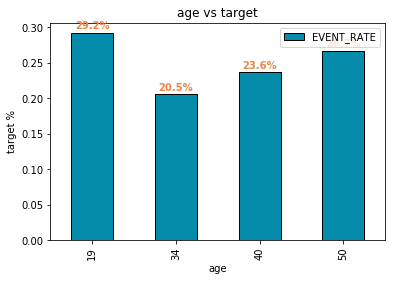

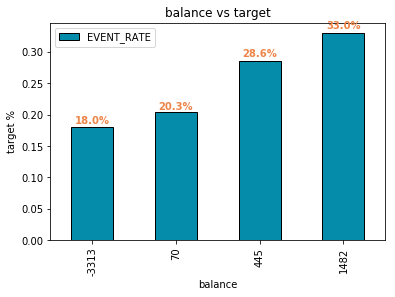

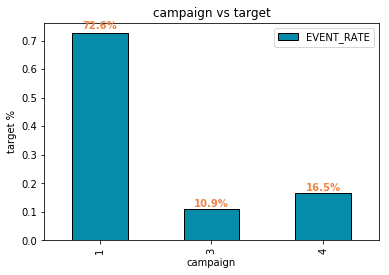

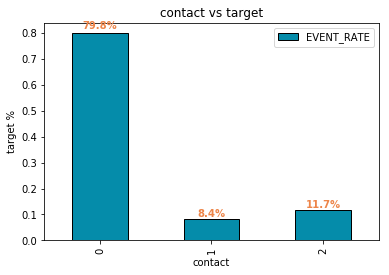

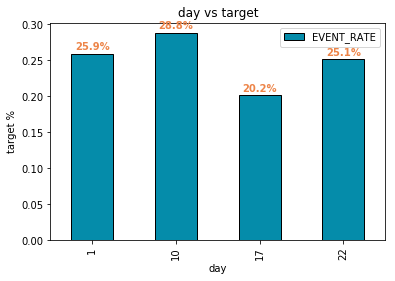

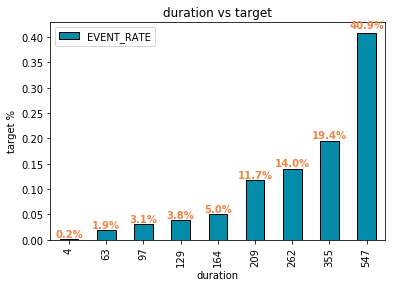

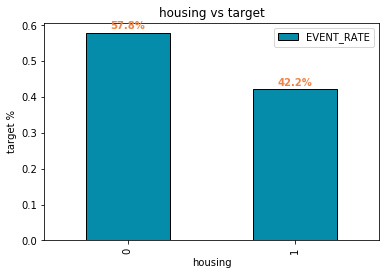

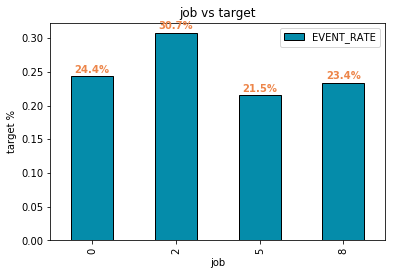

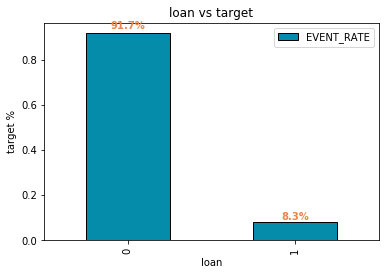

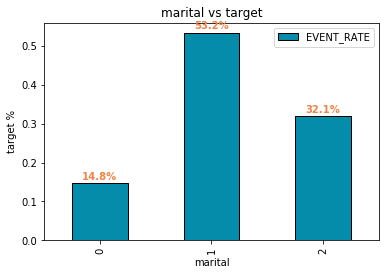

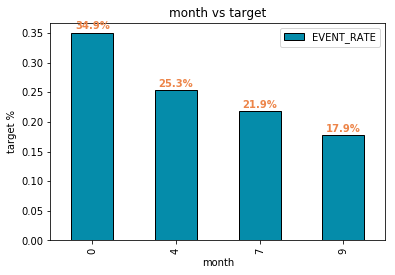

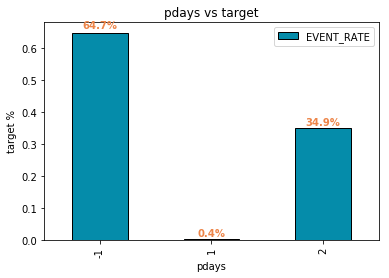

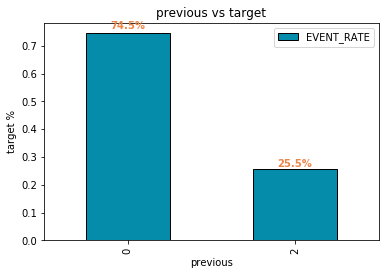

In [46]:
bar_color = '#058caa'
num_color = '#ed8549'

final_iv,_ = data_vars(df1,df1['target'])
final_iv = final_iv[(final_iv.VAR_NAME != 'target')]
grouped = final_iv.groupby(['VAR_NAME'])
for key, group in grouped:
    ax = group.plot('MIN_VALUE','EVENT_RATE',kind='bar',color=bar_color,linewidth=1.0,edgecolor=['black'])
    ax.set_title(str(key) + " vs " + str('target'))
    ax.set_xlabel(key)
    ax.set_ylabel(str('target') + " %")
    rects = ax.patches
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.01*height, str(round(height*100,1)) + '%', 
                ha='center', va='bottom', color=num_color, fontweight='bold')

# 5. Model

In [47]:
from sklearn.cross_validation import train_test_split

train, test = train_test_split(df1, test_size = 0.4)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

features_train = train[list(vif['Features'])]
label_train = train['target']
features_test = test[list(vif['Features'])]
label_test = test['target']

/Users/mbagav200/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Random Forest

In [48]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

0.9863569321533924 0.8844665561083471 0.9988074291834237 0.840104902392145


In [49]:
pd.crosstab(label_train,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,2404,4
1,33,271


In [50]:
pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,1560,32
1,177,40


## Logistic Regression

In [51]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

0.8908554572271387 0.8899944720840243 0.8581660364574226 0.8662089248083737


In [52]:
pd.crosstab(label_train,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,2364,44
1,252,52


In [53]:
pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,1572,20
1,179,38


## Neural Network

In [54]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

0.8635693215339233 0.8352681039248203 0.5410678768141284 0.5057545793483547


In [55]:
pd.crosstab(label_train,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,2268,140
1,230,74


In [56]:
pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,1482,110
1,188,29


## Naive Bayes

In [57]:
from sklearn.naive_bayes import GaussianNB 
clf = GaussianNB()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

0.875 0.8634604754007739 0.8164984590837558 0.8209726628534375


In [58]:
pd.crosstab(label_train,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,2239,169
1,170,134


In [59]:
pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,1466,126
1,121,96


## Gradient Boosting

In [60]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

0.9421091445427728 0.8894416804864566 0.956765551232733 0.881475349095709


In [61]:
pd.crosstab(label_train,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,2385,23
1,134,170


In [62]:
pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,1550,42
1,158,59


# 6. Performance Tuning

# Random Forest - Hyper parameter tuning

In [63]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(3, 10, num = 1)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 2, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(features_train, label_train)

print(rf_random.best_params_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] bootstrap=True, max_depth=None, min_samples_split=5, max_features=sqrt, min_samples_leaf=4, n_estimators=10 
[CV] bootstrap=True, max_depth=None, min_samples_split=5, max_features=sqrt, min_samples_leaf=4, n_estimators=10 
[CV] bootstrap=True, max_depth=None, min_samples_split=10, max_features=sqrt, min_samples_leaf=1, n_estimators=10 
[CV] bootstrap=True, max_depth=None, min_samples_split=10, max_features=sqrt, min_samples_leaf=1, n_estimators=10 
[CV] bootstrap=True, max_depth=3, min_samples_split=10, max_features=auto, min_samples_leaf=2, n_estimators=227 
[CV] bootstrap=True, max_depth=3, min_samples_split=10, max_features=auto, min_samples_leaf=2, n_estimators=227 
[CV]  bootstrap=True, max_depth=None, min_samples_split=5, max_features=sqrt, min_samples_leaf=4, n_estimators=10, total=   0.0s
[CV] bootstrap=True, max_depth=None, min_samples_split=5, max_features=auto, min_samples_leaf=1, n_estimators=445 
[CV]  boots

[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:    0.7s remaining:    2.1s


[CV]  bootstrap=True, max_depth=3, min_samples_split=2, max_features=auto, min_samples_leaf=4, n_estimators=282, total=   0.9s
[CV] bootstrap=True, max_depth=None, min_samples_split=10, max_features=sqrt, min_samples_leaf=1, n_estimators=118 
[CV]  bootstrap=True, max_depth=3, min_samples_split=2, max_features=auto, min_samples_leaf=4, n_estimators=282, total=   0.9s
[CV]  bootstrap=True, max_depth=3, min_samples_split=2, max_features=auto, min_samples_leaf=4, n_estimators=173, total=   0.6s
[CV]  bootstrap=True, max_depth=3, min_samples_split=2, max_features=auto, min_samples_leaf=4, n_estimators=173, total=   0.5s
[CV]  bootstrap=True, max_depth=None, min_samples_split=10, max_features=sqrt, min_samples_leaf=1, n_estimators=118, total=   0.4s
[CV] bootstrap=True, max_depth=None, min_samples_split=10, max_features=sqrt, min_samples_leaf=1, n_estimators=118 
[CV]  bootstrap=True, max_depth=3, min_samples_split=10, max_features=sqrt, min_samples_leaf=2, n_estimators=282, total=   0.8s
[

[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    1.9s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.9s finished


{'bootstrap': True, 'max_depth': None, 'min_samples_split': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 445}


In [64]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(**rf_random.best_params_)

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

0.9889380530973452 0.8839137645107794 0.9999849733344991 0.8951207651159021


## Gradient Boosting - Hyper parameter tuning

In [65]:
from sklearn import cross_validation, metrics   
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(3, 10, num = 1)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

gb = GradientBoostingClassifier()

gf_tune = GridSearchCV(estimator = gb, param_grid = grid, cv = 2, verbose=2, n_jobs = -1)
gf_tune.fit(features_train, label_train)

print(gf_tune.best_params_)

Fitting 2 folds for each of 360 candidates, totalling 720 fits


/Users/mbagav200/anaconda/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


[CV] min_samples_split=2, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=10 
[CV] min_samples_split=2, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=10 
[CV] min_samples_split=2, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=64 
[CV] min_samples_split=2, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=64 
[CV] min_samples_split=2, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=118 
[CV] min_samples_split=2, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=118 
[CV]  min_samples_split=2, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=10 -   0.0s
[CV] min_samples_split=2, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=173 
[CV] min_samples_split=2, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=227 
[CV]  min_samples_split=2, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=10 -   0.0s
[CV] min_samples_split=2, ma

[CV]  min_samples_split=10, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=500 -   1.1s
[CV]  min_samples_split=5, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=282 -   0.6s
[CV] min_samples_split=5, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=282 
[CV] min_samples_split=10, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=500 
[CV]  min_samples_split=2, max_depth=3, max_features=auto, min_samples_leaf=2, n_estimators=118 -   0.3s
[CV]  min_samples_split=5, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=391 -   0.9s
[CV] min_samples_split=2, max_depth=3, max_features=auto, min_samples_leaf=2, n_estimators=173 
[CV] min_samples_split=5, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=445 
[CV]  min_samples_split=2, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=445 -   1.0s
[CV] min_samples_split=2, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimator

[CV]  min_samples_split=10, max_depth=3, max_features=auto, min_samples_leaf=2, n_estimators=64 -   0.1s
[CV] min_samples_split=10, max_depth=3, max_features=auto, min_samples_leaf=2, n_estimators=64 
[CV]  min_samples_split=10, max_depth=3, max_features=auto, min_samples_leaf=2, n_estimators=64 -   0.1s
[CV] min_samples_split=10, max_depth=3, max_features=auto, min_samples_leaf=2, n_estimators=118 
[CV]  min_samples_split=5, max_depth=3, max_features=auto, min_samples_leaf=2, n_estimators=173 -   0.4s
[CV] min_samples_split=5, max_depth=3, max_features=auto, min_samples_leaf=2, n_estimators=173 
[CV]  min_samples_split=5, max_depth=3, max_features=auto, min_samples_leaf=2, n_estimators=227 -   0.5s
[CV] min_samples_split=5, max_depth=3, max_features=auto, min_samples_leaf=2, n_estimators=282 
[CV]  min_samples_split=5, max_depth=3, max_features=auto, min_samples_leaf=2, n_estimators=391 -   0.9s
[CV] min_samples_split=5, max_depth=3, max_features=auto, min_samples_leaf=2, n_estimators

[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    6.2s


[CV]  min_samples_split=5, max_depth=3, max_features=auto, min_samples_leaf=2, n_estimators=282 -   0.7s
[CV] min_samples_split=5, max_depth=3, max_features=auto, min_samples_leaf=2, n_estimators=282 
[CV]  min_samples_split=10, max_depth=3, max_features=auto, min_samples_leaf=2, n_estimators=173 -   0.4s
[CV] min_samples_split=10, max_depth=3, max_features=auto, min_samples_leaf=2, n_estimators=173 
[CV]  min_samples_split=5, max_depth=3, max_features=auto, min_samples_leaf=2, n_estimators=391 -   1.0s
[CV] min_samples_split=5, max_depth=3, max_features=auto, min_samples_leaf=2, n_estimators=445 
[CV]  min_samples_split=10, max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=445 -   1.1s
[CV] min_samples_split=10, max_depth=3, max_features=auto, min_samples_leaf=2, n_estimators=500 
[CV]  min_samples_split=10, max_depth=3, max_features=auto, min_samples_leaf=2, n_estimators=173 -   0.4s
[CV] min_samples_split=10, max_depth=3, max_features=auto, min_samples_leaf=2, n_estim

[CV]  min_samples_split=2, max_depth=3, max_features=auto, min_samples_leaf=4, n_estimators=445 -   1.0s
[CV] min_samples_split=2, max_depth=3, max_features=auto, min_samples_leaf=4, n_estimators=445 
[CV]  min_samples_split=5, max_depth=3, max_features=auto, min_samples_leaf=4, n_estimators=118 -   0.3s
[CV] min_samples_split=5, max_depth=3, max_features=auto, min_samples_leaf=4, n_estimators=173 
[CV]  min_samples_split=2, max_depth=3, max_features=auto, min_samples_leaf=4, n_estimators=500 -   1.2s
[CV] min_samples_split=5, max_depth=3, max_features=auto, min_samples_leaf=4, n_estimators=10 
[CV]  min_samples_split=5, max_depth=3, max_features=auto, min_samples_leaf=4, n_estimators=10 -   0.0s
[CV]  min_samples_split=5, max_depth=3, max_features=auto, min_samples_leaf=4, n_estimators=118 -   0.3s
[CV] min_samples_split=5, max_depth=3, max_features=auto, min_samples_leaf=4, n_estimators=10 
[CV]  min_samples_split=5, max_depth=3, max_features=auto, min_samples_leaf=2, n_estimators=50

[CV]  min_samples_split=10, max_depth=3, max_features=auto, min_samples_leaf=4, n_estimators=336 -   0.8s
[CV] min_samples_split=2, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=10 
[CV]  min_samples_split=2, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=10 -   0.0s
[CV] min_samples_split=2, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=10 
[CV]  min_samples_split=2, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=10 -   0.0s
[CV] min_samples_split=2, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=64 
[CV]  min_samples_split=10, max_depth=3, max_features=auto, min_samples_leaf=4, n_estimators=336 -   0.8s
[CV] min_samples_split=2, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=64 
[CV]  min_samples_split=2, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=64 -   0.1s
[CV] min_samples_split=2, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=118 


[CV]  min_samples_split=10, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=10 -   0.0s
[CV] min_samples_split=10, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=10 
[CV]  min_samples_split=5, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=336 -   0.5s
[CV]  min_samples_split=10, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=10 -   0.0s
[CV] min_samples_split=10, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=64 
[CV] min_samples_split=10, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=64 
[CV]  min_samples_split=10, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=64 -   0.1s
[CV]  min_samples_split=10, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=64 -   0.1s
[CV] min_samples_split=10, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=118 
[CV] min_samples_split=10, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimator

[CV]  min_samples_split=5, max_depth=3, max_features=sqrt, min_samples_leaf=2, n_estimators=10 -   0.0s
[CV] min_samples_split=5, max_depth=3, max_features=sqrt, min_samples_leaf=2, n_estimators=64 
[CV]  min_samples_split=5, max_depth=3, max_features=sqrt, min_samples_leaf=2, n_estimators=10 -   0.0s
[CV] min_samples_split=5, max_depth=3, max_features=sqrt, min_samples_leaf=2, n_estimators=64 
[CV]  min_samples_split=5, max_depth=3, max_features=sqrt, min_samples_leaf=2, n_estimators=64 -   0.1s
[CV] min_samples_split=5, max_depth=3, max_features=sqrt, min_samples_leaf=2, n_estimators=118 
[CV]  min_samples_split=5, max_depth=3, max_features=sqrt, min_samples_leaf=2, n_estimators=64 -   0.1s
[CV] min_samples_split=5, max_depth=3, max_features=sqrt, min_samples_leaf=2, n_estimators=118 
[CV]  min_samples_split=2, max_depth=3, max_features=sqrt, min_samples_leaf=2, n_estimators=391 -   0.7s
[CV] min_samples_split=5, max_depth=3, max_features=sqrt, min_samples_leaf=2, n_estimators=173 


[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   17.9s


[CV]  min_samples_split=2, max_depth=3, max_features=sqrt, min_samples_leaf=2, n_estimators=391 -   0.6s
[CV] min_samples_split=5, max_depth=3, max_features=sqrt, min_samples_leaf=2, n_estimators=173 
[CV]  min_samples_split=5, max_depth=3, max_features=sqrt, min_samples_leaf=2, n_estimators=118 -   0.2s
[CV] min_samples_split=5, max_depth=3, max_features=sqrt, min_samples_leaf=2, n_estimators=227 
[CV]  min_samples_split=5, max_depth=3, max_features=sqrt, min_samples_leaf=2, n_estimators=118 -   0.2s
[CV] min_samples_split=5, max_depth=3, max_features=sqrt, min_samples_leaf=2, n_estimators=227 
[CV]  min_samples_split=2, max_depth=3, max_features=sqrt, min_samples_leaf=2, n_estimators=445 -   0.8s
[CV]  min_samples_split=2, max_depth=3, max_features=sqrt, min_samples_leaf=2, n_estimators=445 -   0.7s
[CV] min_samples_split=5, max_depth=3, max_features=sqrt, min_samples_leaf=2, n_estimators=282 
[CV] min_samples_split=5, max_depth=3, max_features=sqrt, min_samples_leaf=2, n_estimators=

[CV]  min_samples_split=2, max_depth=3, max_features=sqrt, min_samples_leaf=4, n_estimators=118 -   0.2s
[CV] min_samples_split=2, max_depth=3, max_features=sqrt, min_samples_leaf=4, n_estimators=227 
[CV]  min_samples_split=10, max_depth=3, max_features=sqrt, min_samples_leaf=2, n_estimators=445 -   0.7s
[CV]  min_samples_split=10, max_depth=3, max_features=sqrt, min_samples_leaf=2, n_estimators=445 -   0.7s
[CV] min_samples_split=2, max_depth=3, max_features=sqrt, min_samples_leaf=4, n_estimators=227 
[CV]  min_samples_split=2, max_depth=3, max_features=sqrt, min_samples_leaf=4, n_estimators=118 -   0.2s
[CV] min_samples_split=2, max_depth=3, max_features=sqrt, min_samples_leaf=4, n_estimators=282 
[CV] min_samples_split=2, max_depth=3, max_features=sqrt, min_samples_leaf=4, n_estimators=282 
[CV]  min_samples_split=2, max_depth=3, max_features=sqrt, min_samples_leaf=4, n_estimators=173 -   0.3s
[CV] min_samples_split=2, max_depth=3, max_features=sqrt, min_samples_leaf=4, n_estimator

[CV]  min_samples_split=10, max_depth=3, max_features=sqrt, min_samples_leaf=4, n_estimators=118 -   0.2s
[CV]  min_samples_split=5, max_depth=3, max_features=sqrt, min_samples_leaf=4, n_estimators=445 -   0.7s
[CV] min_samples_split=10, max_depth=3, max_features=sqrt, min_samples_leaf=4, n_estimators=227 
[CV] min_samples_split=10, max_depth=3, max_features=sqrt, min_samples_leaf=4, n_estimators=282 
[CV]  min_samples_split=5, max_depth=3, max_features=sqrt, min_samples_leaf=4, n_estimators=445 -   0.7s
[CV] min_samples_split=10, max_depth=3, max_features=sqrt, min_samples_leaf=4, n_estimators=282 
[CV]  min_samples_split=10, max_depth=3, max_features=sqrt, min_samples_leaf=4, n_estimators=173 -   0.3s
[CV]  min_samples_split=10, max_depth=3, max_features=sqrt, min_samples_leaf=4, n_estimators=173 -   0.3s
[CV] min_samples_split=10, max_depth=3, max_features=sqrt, min_samples_leaf=4, n_estimators=336 
[CV] min_samples_split=10, max_depth=3, max_features=sqrt, min_samples_leaf=4, n_est

[CV]  min_samples_split=2, max_depth=None, max_features=auto, min_samples_leaf=1, n_estimators=500 -   1.6s
[CV] min_samples_split=5, max_depth=None, max_features=auto, min_samples_leaf=1, n_estimators=227 
[CV]  min_samples_split=5, max_depth=None, max_features=auto, min_samples_leaf=1, n_estimators=64 -   1.4s
[CV] min_samples_split=5, max_depth=None, max_features=auto, min_samples_leaf=1, n_estimators=282 
[CV]  min_samples_split=5, max_depth=None, max_features=auto, min_samples_leaf=1, n_estimators=64 -   1.7s
[CV] min_samples_split=5, max_depth=None, max_features=auto, min_samples_leaf=1, n_estimators=282 
[CV]  min_samples_split=5, max_depth=None, max_features=auto, min_samples_leaf=1, n_estimators=118 -   1.6s
[CV] min_samples_split=5, max_depth=None, max_features=auto, min_samples_leaf=1, n_estimators=336 
[CV]  min_samples_split=5, max_depth=None, max_features=auto, min_samples_leaf=1, n_estimators=173 -   1.7s
[CV] min_samples_split=5, max_depth=None, max_features=auto, min_s

[CV] min_samples_split=2, max_depth=None, max_features=auto, min_samples_leaf=2, n_estimators=227 
[CV]  min_samples_split=2, max_depth=None, max_features=auto, min_samples_leaf=2, n_estimators=64 -   1.5s
[CV] min_samples_split=2, max_depth=None, max_features=auto, min_samples_leaf=2, n_estimators=227 
[CV]  min_samples_split=10, max_depth=None, max_features=auto, min_samples_leaf=1, n_estimators=500 -   2.6s
[CV] min_samples_split=2, max_depth=None, max_features=auto, min_samples_leaf=2, n_estimators=282 
[CV]  min_samples_split=2, max_depth=None, max_features=auto, min_samples_leaf=2, n_estimators=118 -   1.8s
[CV] min_samples_split=2, max_depth=None, max_features=auto, min_samples_leaf=2, n_estimators=282 
[CV]  min_samples_split=2, max_depth=None, max_features=auto, min_samples_leaf=2, n_estimators=64 -   1.9s
[CV] min_samples_split=2, max_depth=None, max_features=auto, min_samples_leaf=2, n_estimators=336 
[CV]  min_samples_split=2, max_depth=None, max_features=auto, min_samples_

[Parallel(n_jobs=-1)]: Done 459 tasks      | elapsed:   46.4s


[CV]  min_samples_split=5, max_depth=None, max_features=auto, min_samples_leaf=2, n_estimators=445 -   2.0s
[CV] min_samples_split=10, max_depth=None, max_features=auto, min_samples_leaf=2, n_estimators=227 
[CV]  min_samples_split=10, max_depth=None, max_features=auto, min_samples_leaf=2, n_estimators=64 -   1.4s
[CV] min_samples_split=10, max_depth=None, max_features=auto, min_samples_leaf=2, n_estimators=227 
[CV]  min_samples_split=5, max_depth=None, max_features=auto, min_samples_leaf=2, n_estimators=500 -   2.1s
[CV] min_samples_split=10, max_depth=None, max_features=auto, min_samples_leaf=2, n_estimators=282 
[CV]  min_samples_split=10, max_depth=None, max_features=auto, min_samples_leaf=2, n_estimators=64 -   1.5s
[CV] min_samples_split=10, max_depth=None, max_features=auto, min_samples_leaf=2, n_estimators=282 
[CV]  min_samples_split=10, max_depth=None, max_features=auto, min_samples_leaf=2, n_estimators=118 -   1.9s
[CV] min_samples_split=10, max_depth=None, max_features=aut

[CV] min_samples_split=5, max_depth=None, max_features=auto, min_samples_leaf=4, n_estimators=173 
[CV]  min_samples_split=5, max_depth=None, max_features=auto, min_samples_leaf=4, n_estimators=64 -   1.7s
[CV] min_samples_split=5, max_depth=None, max_features=auto, min_samples_leaf=4, n_estimators=227 
[CV]  min_samples_split=2, max_depth=None, max_features=auto, min_samples_leaf=4, n_estimators=500 -   3.1s
[CV] min_samples_split=5, max_depth=None, max_features=auto, min_samples_leaf=4, n_estimators=227 
[CV]  min_samples_split=2, max_depth=None, max_features=auto, min_samples_leaf=4, n_estimators=500 -   3.3s
[CV]  min_samples_split=5, max_depth=None, max_features=auto, min_samples_leaf=4, n_estimators=64 -   2.0s
[CV] min_samples_split=5, max_depth=None, max_features=auto, min_samples_leaf=4, n_estimators=282 
[CV] min_samples_split=5, max_depth=None, max_features=auto, min_samples_leaf=4, n_estimators=282 
[CV]  min_samples_split=5, max_depth=None, max_features=auto, min_samples_l

[CV] min_samples_split=2, max_depth=None, max_features=sqrt, min_samples_leaf=1, n_estimators=173 
[CV]  min_samples_split=2, max_depth=None, max_features=sqrt, min_samples_leaf=1, n_estimators=64 -   1.2s
[CV] min_samples_split=2, max_depth=None, max_features=sqrt, min_samples_leaf=1, n_estimators=227 
[CV]  min_samples_split=10, max_depth=None, max_features=auto, min_samples_leaf=4, n_estimators=500 -   3.1s
[CV] min_samples_split=2, max_depth=None, max_features=sqrt, min_samples_leaf=1, n_estimators=227 
[CV]  min_samples_split=10, max_depth=None, max_features=auto, min_samples_leaf=4, n_estimators=445 -   3.2s
[CV] min_samples_split=2, max_depth=None, max_features=sqrt, min_samples_leaf=1, n_estimators=282 
[CV]  min_samples_split=10, max_depth=None, max_features=auto, min_samples_leaf=4, n_estimators=500 -   3.0s
[CV] min_samples_split=2, max_depth=None, max_features=sqrt, min_samples_leaf=1, n_estimators=282 
[CV]  min_samples_split=2, max_depth=None, max_features=sqrt, min_sampl

[CV] min_samples_split=10, max_depth=None, max_features=sqrt, min_samples_leaf=1, n_estimators=173 
[CV]  min_samples_split=5, max_depth=None, max_features=sqrt, min_samples_leaf=1, n_estimators=500 -   2.3s
[CV] min_samples_split=10, max_depth=None, max_features=sqrt, min_samples_leaf=1, n_estimators=227 
[CV]  min_samples_split=10, max_depth=None, max_features=sqrt, min_samples_leaf=1, n_estimators=64 -   1.5s
[CV] min_samples_split=10, max_depth=None, max_features=sqrt, min_samples_leaf=1, n_estimators=227 
[CV]  min_samples_split=10, max_depth=None, max_features=sqrt, min_samples_leaf=1, n_estimators=64 -   1.5s
[CV] min_samples_split=10, max_depth=None, max_features=sqrt, min_samples_leaf=1, n_estimators=282 
[CV]  min_samples_split=5, max_depth=None, max_features=sqrt, min_samples_leaf=1, n_estimators=500 -   2.4s
[CV] min_samples_split=10, max_depth=None, max_features=sqrt, min_samples_leaf=1, n_estimators=282 
[CV]  min_samples_split=10, max_depth=None, max_features=sqrt, min_s

[CV] min_samples_split=5, max_depth=None, max_features=sqrt, min_samples_leaf=2, n_estimators=173 
[CV]  min_samples_split=2, max_depth=None, max_features=sqrt, min_samples_leaf=2, n_estimators=500 -   3.0s
[CV] min_samples_split=5, max_depth=None, max_features=sqrt, min_samples_leaf=2, n_estimators=227 
[CV]  min_samples_split=5, max_depth=None, max_features=sqrt, min_samples_leaf=2, n_estimators=64 -   2.0s
[CV] min_samples_split=5, max_depth=None, max_features=sqrt, min_samples_leaf=2, n_estimators=227 
[CV]  min_samples_split=2, max_depth=None, max_features=sqrt, min_samples_leaf=2, n_estimators=500 -   3.0s
[CV] min_samples_split=5, max_depth=None, max_features=sqrt, min_samples_leaf=2, n_estimators=282 
[CV]  min_samples_split=5, max_depth=None, max_features=sqrt, min_samples_leaf=2, n_estimators=64 -   2.0s
[CV] min_samples_split=5, max_depth=None, max_features=sqrt, min_samples_leaf=2, n_estimators=282 
[CV]  min_samples_split=5, max_depth=None, max_features=sqrt, min_samples_l

[CV]  min_samples_split=10, max_depth=None, max_features=sqrt, min_samples_leaf=2, n_estimators=500 -   2.2s
[CV] min_samples_split=2, max_depth=None, max_features=sqrt, min_samples_leaf=4, n_estimators=173 
[CV]  min_samples_split=10, max_depth=None, max_features=sqrt, min_samples_leaf=2, n_estimators=445 -   2.2s
[CV] min_samples_split=2, max_depth=None, max_features=sqrt, min_samples_leaf=4, n_estimators=227 
[CV]  min_samples_split=2, max_depth=None, max_features=sqrt, min_samples_leaf=4, n_estimators=64 -   1.3s
[CV] min_samples_split=2, max_depth=None, max_features=sqrt, min_samples_leaf=4, n_estimators=227 
[CV]  min_samples_split=10, max_depth=None, max_features=sqrt, min_samples_leaf=2, n_estimators=500 -   2.3s
[CV] min_samples_split=2, max_depth=None, max_features=sqrt, min_samples_leaf=4, n_estimators=282 
[CV]  min_samples_split=2, max_depth=None, max_features=sqrt, min_samples_leaf=4, n_estimators=64 -   1.4s
[CV] min_samples_split=2, max_depth=None, max_features=sqrt, mi

[CV]  min_samples_split=5, max_depth=None, max_features=sqrt, min_samples_leaf=4, n_estimators=500 -   2.2s
[CV] min_samples_split=10, max_depth=None, max_features=sqrt, min_samples_leaf=4, n_estimators=173 
[CV]  min_samples_split=5, max_depth=None, max_features=sqrt, min_samples_leaf=4, n_estimators=445 -   2.3s
[CV] min_samples_split=10, max_depth=None, max_features=sqrt, min_samples_leaf=4, n_estimators=227 
[CV]  min_samples_split=10, max_depth=None, max_features=sqrt, min_samples_leaf=4, n_estimators=64 -   1.1s
[CV] min_samples_split=10, max_depth=None, max_features=sqrt, min_samples_leaf=4, n_estimators=227 
[CV]  min_samples_split=10, max_depth=None, max_features=sqrt, min_samples_leaf=4, n_estimators=64 -   1.1s
[CV] min_samples_split=10, max_depth=None, max_features=sqrt, min_samples_leaf=4, n_estimators=282 
[CV]  min_samples_split=5, max_depth=None, max_features=sqrt, min_samples_leaf=4, n_estimators=500 -   2.3s
[CV] min_samples_split=10, max_depth=None, max_features=sqrt

[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  1.9min finished


{'min_samples_split': 2, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 118}


In [66]:
print(gf_tune.best_params_)

{'min_samples_split': 2, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 118}


In [67]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(**gf_tune.best_params_)

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

1.0 0.8794914317302377 1.0 0.88284741680754


# 7. Final Model and Model Performance

In [68]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

0.8908554572271387 0.8899944720840243 0.857780807396398 0.8654939443762593


In [69]:
pd.crosstab(label_train,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,2364,44
1,252,52


In [70]:
pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,1571,21
1,178,39


In [71]:
from bokeh.charts import Histogram
from ipywidgets import interact
from bokeh.plotting import figure
from bokeh.io import push_notebook, show, output_notebook
output_notebook()

from sklearn import metrics
preds = clf.predict_proba(features_train)[:,1]

fpr, tpr, _ = metrics.roc_curve(np.array(label_train), preds)
auc = metrics.auc(fpr,tpr)

p = figure(title="ROC Curve - Train data")
r = p.line(fpr,tpr,color='#0077bc',legend = 'AUC = '+ str(round(auc,3)), line_width=2)
s = p.line([0,1],[0,1], color= '#d15555',line_dash='dotdash',line_width=2)
show(p)

Loading BokehJS ...

In [72]:
from bokeh.charts import Histogram
from ipywidgets import interact
from bokeh.plotting import figure
from bokeh.io import push_notebook, show, output_notebook
output_notebook()

from sklearn import metrics
preds = clf.predict_proba(features_test)[:,1]

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), preds)
auc = metrics.auc(fpr,tpr)

p = figure(title="ROC Curve - Test data")
r = p.line(fpr,tpr,color='#0077bc',legend = 'AUC = '+ str(round(auc,3)), line_width=2)
s = p.line([0,1],[0,1], color= '#d15555',line_dash='dotdash',line_width=2)
show(p)

Loading BokehJS ...

## Decile Plots and KS statistic

In [73]:
from collections import OrderedDict
import pandas as pd
import sys
%matplotlib inline
    
def plot_pandas_style(styler):
    from IPython.core.display import HTML
    html = '\n'.join([line.lstrip() for line in styler.render().split('\n')])
    return HTML(html)

def highlight_max(s,color='yellow'):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: {}'.format(color) if v else '' for v in is_max]

def decile_labels(agg1,label,color='skyblue'):
    agg_dummy = pd.DataFrame(OrderedDict((('TOTAL',0),('TARGET',0),('NONTARGET',0),('PCT_TAR',0),('CUM_TAR',0),('CUM_NONTAR',0),('DIST_TAR',0),('DIST_NONTAR',0),('SPREAD',0))),index=[0])
    agg1 = agg1.append(agg_dummy).sort_index()
    agg1.index.name = label
    agg1 = agg1.style.apply(highlight_max, color = 'yellow', subset=['SPREAD'])
    agg1.bar(subset=['TARGET'], color='{}'.format(color))
    agg1.bar(subset=['TOTAL'], color='{}'.format(color))
    agg1.bar(subset=['PCT_TAR'], color='{}'.format(color))
    return(agg1)

def deciling(data,decile_by,target,nontarget):
    inputs = list(decile_by)
    inputs.extend((target,nontarget))
    decile = data[inputs]
    grouped = decile.groupby(decile_by)
    agg1 = pd.DataFrame({},index=[])
    agg1['TOTAL'] = grouped.sum()[nontarget] + grouped.sum()[target]
    agg1['TARGET'] = grouped.sum()[target]
    agg1['NONTARGET'] = grouped.sum()[nontarget]
    agg1['PCT_TAR'] = grouped.mean()[target]*100
    agg1['CUM_TAR'] = grouped.sum()[target].cumsum()
    agg1['CUM_NONTAR'] = grouped.sum()[nontarget].cumsum()
    agg1['DIST_TAR'] = agg1['CUM_TAR']/agg1['TARGET'].sum()*100
    agg1['DIST_NONTAR'] = agg1['CUM_NONTAR']/agg1['NONTARGET'].sum()*100
    agg1['SPREAD'] = (agg1['DIST_TAR'] - agg1['DIST_NONTAR'])
    agg1 = decile_labels(agg1,'DECILE',color='skyblue')
    return(plot_pandas_style(agg1))

In [74]:
def scoring(features,clf,target):
    score = pd.DataFrame(clf.predict_proba(features)[:,1], columns = ['SCORE'])
    score['DECILE'] = pd.qcut(score['SCORE'].rank(method = 'first'),10,labels=range(10,0,-1))
    score['DECILE'] = score['DECILE'].astype(float)
    score['TARGET'] = target
    score['NONTARGET'] = 1 - target
    return(score)

In [75]:
scores_train = scoring(features_train,clf,label_train)
scores_test = scoring(features_test,clf,label_test)

In [76]:
deciling(scores_train,['DECILE'],'TARGET','NONTARGET')

,TOTAL,TARGET,NONTARGET,PCT_TAR,CUM_TAR,CUM_NONTAR,DIST_TAR,DIST_NONTAR,SPREAD
DECILE,,,,,,,,,
0.0,0,0,0,0,0,0,0,0,0
1.0,272,131,141,48.1618,131,141,43.0921,5.85548,37.2366
2.0,271,77,194,28.4133,208,335,68.4211,13.912,54.5091
3.0,271,36,235,13.2841,244,570,80.2632,23.6711,56.5921
4.0,271,24,247,8.85609,268,817,88.1579,33.9286,54.2293
5.0,271,13,258,4.79705,281,1075,92.4342,44.6429,47.7914
6.0,271,9,262,3.32103,290,1337,95.3947,55.5233,39.8715
7.0,271,6,265,2.21402,296,1602,97.3684,66.5282,30.8402
8.0,271,3,268,1.10701,299,1870,98.3553,77.6578,20.6975


In [77]:
deciling(scores_test,['DECILE'],'TARGET','NONTARGET')

,TOTAL,TARGET,NONTARGET,PCT_TAR,CUM_TAR,CUM_NONTAR,DIST_TAR,DIST_NONTAR,SPREAD
DECILE,,,,,,,,,
0.0,0,0,0,0,0,0,0,0,0
1.0,181,92,89,50.8287,92,89,42.3963,5.59045,36.8059
2.0,181,53,128,29.2818,145,217,66.8203,13.6307,53.1896
3.0,181,31,150,17.1271,176,367,81.106,23.0528,58.0532
4.0,181,17,164,9.39227,193,531,88.9401,33.3543,55.5858
5.0,180,10,170,5.55556,203,701,93.5484,44.0327,49.5157
6.0,181,7,174,3.8674,210,875,96.7742,54.9623,41.8119
7.0,181,4,177,2.20994,214,1052,98.6175,66.0804,32.5371
8.0,181,2,179,1.10497,216,1231,99.5392,77.3241,22.215


## Lift chart, Actual vs predicted and Gains chart

In [78]:
from collections import OrderedDict
import pandas as pd
import matplotlib.pyplot as plt

def plots(agg1,target,type):

    plt.figure(1,figsize=(20, 5))

    plt.subplot(131)
    plt.plot(agg1['DECILE'],agg1['ACTUAL'],label='Actual')
    plt.plot(agg1['DECILE'],agg1['PRED'],label='Pred')
    plt.xticks(range(10,110,10))
    plt.legend(fontsize=15)
    plt.grid(True)
    plt.title('Actual vs Predicted', fontsize=20)
    plt.xlabel("Population %",fontsize=15)
    plt.ylabel(str(target) + " " + str(type) + " %",fontsize=15)

    plt.subplot(132)
    X = agg1['DECILE'].tolist()
    X.append(0)
    Y = agg1['DIST_TAR'].tolist()
    Y.append(0)
    plt.plot(sorted(X),sorted(Y))
    plt.plot([0, 100], [0, 100],'r--')
    plt.xticks(range(0,110,10))
    plt.yticks(range(0,110,10))
    plt.grid(True)
    plt.title('Gains Chart', fontsize=20)
    plt.xlabel("Population %",fontsize=15)
    plt.ylabel(str(target) + str(" DISTRIBUTION") + " %",fontsize=15)
    plt.annotate(round(agg1[agg1['DECILE'] == 30].DIST_TAR.item(),2),xy=[30,30], 
            xytext=(25, agg1[agg1['DECILE'] == 30].DIST_TAR.item() + 5),fontsize = 13)
    plt.annotate(round(agg1[agg1['DECILE'] == 50].DIST_TAR.item(),2),xy=[50,50], 
            xytext=(45, agg1[agg1['DECILE'] == 50].DIST_TAR.item() + 5),fontsize = 13)

    plt.subplot(133)
    plt.plot(agg1['DECILE'],agg1['LIFT'])
    plt.xticks(range(10,110,10))
    plt.grid(True)
    plt.title('Lift Chart', fontsize=20)
    plt.xlabel("Population %",fontsize=15)
    plt.ylabel("Lift",fontsize=15)

    plt.tight_layout()

In [79]:
def gains(data,decile_by,target,score):
    inputs = list(decile_by)
    inputs.extend((target,score))
    decile = data[inputs]
    grouped = decile.groupby(decile_by)
    agg1 = pd.DataFrame({},index=[])
    agg1['ACTUAL'] = grouped.mean()[target]*100
    agg1['PRED'] = grouped.mean()[score]*100
    agg1['DIST_TAR'] = grouped.sum()[target].cumsum()/grouped.sum()[target].sum()*100
    agg1.index.name = 'DECILE'
    agg1 = agg1.reset_index()
    agg1['DECILE'] = agg1['DECILE']*10
    agg1['LIFT'] = agg1['DIST_TAR']/agg1['DECILE']
    plots(agg1,target,'Distribution')

In [80]:
lift_train = pd.concat([features_train,scores_train],axis=1)
lift_test = pd.concat([features_test,scores_test],axis=1)

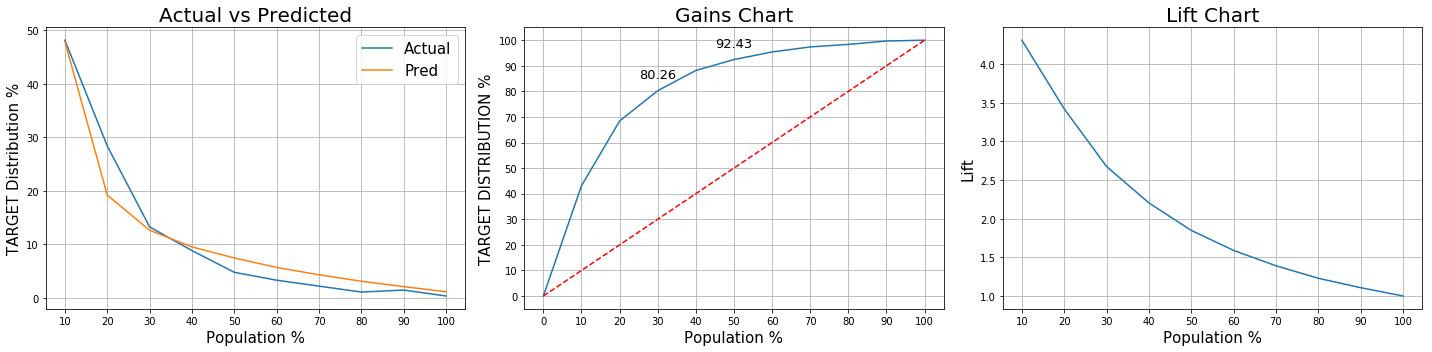

In [81]:
gains(lift_train,['DECILE'],'TARGET','SCORE')

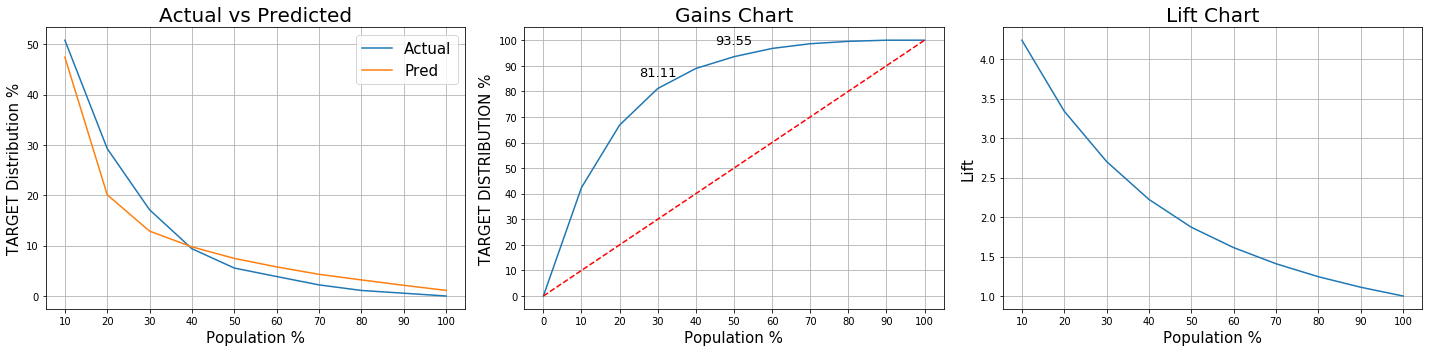

In [82]:
gains(lift_test,['DECILE'],'TARGET','SCORE')

# Save Model for future use

In [83]:
import pandas
from sklearn.externals import joblib

filename = 'final_model.model'
i = [d,clf]
joblib.dump(i,filename)

['final_model.model']

# Score New data

In [84]:
# Use the code to load the model
filename = 'final_model.model'

from sklearn.externals import joblib
d,clf=joblib.load(filename)

In [85]:
def score_new(features,clf):
    score = pd.DataFrame(clf.predict_proba(features)[:,1], columns = ['SCORE'])
    score['DECILE'] = pd.qcut(score['SCORE'].rank(method = 'first'),10,labels=range(10,0,-1))
    score['DECILE'] = score['DECILE'].astype(float)
    return(score)

In [86]:
scores = score_new(new_score_data,clf)

NameError: name 'new_score_data' is not defined